In [58]:

#%% Delta
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

""" configuration """
folder = 'Permanent_water' # Permanent_water, Reservoirs
area = 'permanent_area' # permanent_area, seasonal_area
save_flag = True 

basin_level = 6 # basin level
alpha = 2 # mean +/- alpha * std
p_thd = 0.05

df = pd.DataFrame([], columns=['folder', 'area', 'basin_level', 'alpha', 'p_thd', 'num_of_masked_basins', 
                                'thd_low', 'thd_high', 'method', 'neg', 'stable', 'pos'])
df.to_csv(f'maps/{folder}_{area}.csv', mode='w')

# for alpha in [1, 1.5, 2, 2.5, 3]:
#     for p_thd in [0.01, 0.02, 0.025, 0.05]:

print()
print(f"----------------------- alpha: {alpha}, p_thd: {p_thd} --------------------------------------")

""" delta """
delta = pd.read_csv(f"outputs_delta/{folder}/{area}/basins_level_{basin_level}_ts_delta.csv")
delta = delta[delta['start_year']==2017]

delta['PFAF_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
delta['Country_ID'] = delta['id_bgl'].transform(lambda id: eval(id.split("_")[-1]))
# delta = delta[(delta['Country_ID'] == Country_ID)]  
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}_basins_level_6_delta.csv')

""" delta thresholds """
df_thd = pd.read_csv(f"outputs_delta/{folder}/{area}/basin_level_mean_std.csv").set_index('basin_level')
mean = df_thd[f'mean_{area}'].loc[basin_level]
std = df_thd[f'std_{area}'].loc[basin_level]
print(f"mean: {mean}, std: {std}")

thd_low = mean - alpha * std 
thd_high = mean + alpha * std 
print(f"thd_low: {thd_low}, thd_high: {thd_high}")

def get_sign(x):
    if x < thd_low: return -1.0
    if x > thd_high: return 1.0
    return 0.0

delta['sign'] = delta[area].transform(get_sign)

#%% U-TEST

def get_u_sign(delta_value):
    if delta_value < 0: return -1
    elif delta_value > 0: return 1
    else: return 0

# p_thd = 0.05
# min_area_thd = 0.01 
u_test = pd.read_csv(f"outputs_utest/{folder}/{area}/basins_level_{basin_level}_utest.csv")
u_test['u_flag'] = u_test['p_u'].transform(lambda x: float(x < p_thd)) # u_flag determines whether a basin change or not

# u_test['u_sign'] = u_test['delta'].transform(lambda x: get_u_sign(x))
# u_test['u_sign'][u_test['baseline_median'] < min_area_thd] = -99
u_test['u_sign'][u_test['u_sign'] == -99] = 0
u_test['u_sign'] = u_test['u_sign'] * u_test['u_flag']

if 'id' in u_test.columns: u_test = u_test.rename(columns={'id': 'id_bgl'})

u_test['PFAF_ID'] = u_test['id_bgl'].transform(lambda id: eval(id.split("_")[0]))
# u_test['u_sign'] = u_test['u_score'].transform(lambda x:  np.round(x / (abs(x) + 1e-3))) * u_test['u_sign']
u_test = u_test.rename(columns={'id': 'id_bgl'})
# df.set_index('PFAF_ID').dropna().to_csv(f'outputs_map/{folder}/basins_level_6_utest_p_thd_0_01.csv')
# u_test

#%% Merge DataFrame

""" merge delta and utest """
delta_u = pd.merge(delta, u_test, on='id_bgl')
delta_u = delta_u.rename(columns={'PFAF_ID_x': 'PFAF_ID'})

# apply delta based mask on utest
delta_u['delta_mask'] = 1
delta_u['delta_mask'][(thd_low <= delta_u['delta']) & (delta_u['delta'] <= thd_high)] = 0
delta_u['u_sign'] = delta_u['u_sign'] * delta_u['delta_mask']

num_before_basin_masking = delta_u.shape[0]
print(f"before applying masked_basins: {num_before_basin_masking}")

masked_basins = gpd.read_file("data\Masked__basins\SNow_Arid_Mask.shp")
masked_basins['PFAF_ID_6'] = masked_basins['PFAF_ID_6'].transform(lambda x: eval(x))
delta_u = delta_u[~delta_u['PFAF_ID'].isin(masked_basins['PFAF_ID_6'].unique())]
# delta_u

print(f"after applying masked_basins: {delta_u.shape[0]}")
num_of_masked_basins = num_before_basin_masking - delta_u.shape[0]
print(f"number of masked basins: {num_of_masked_basins}")


----------------------- alpha: 2, p_thd: 0.05 --------------------------------------
mean: -0.768410471435599, std: 14.397894467900349
thd_low: -29.564199407236295, thd_high: 28.0273784643651
before applying masked_basins: 19163
after applying masked_basins: 13893
number of masked basins: 5270


In [57]:
print(df_thd[f'mean_{area}'].loc[basin_level])
print(df_thd[f'std_{area}'].loc[basin_level])

print(df_thd[f'mean_{area}'])


-0.0857345316429409
1.753821090649771
basin_level
0    0.219480
3   -0.096246
4   -0.226419
5   -0.131699
6   -0.085735
7   -0.020199
8   -0.000777
Name: mean_permanent_area, dtype: float64


total_number_basins = 19163
p_th: 0.01, numer of changed basins: 637, percentage: 3.32%
p_th: 0.02, numer of changed basins: 889, percentage: 4.64%
p_th: 0.025, numer of changed basins: 1029, percentage: 5.37%
p_th: 0.05, numer of changed basins: 1357, percentage: 7.08%
p_th: 0.1, numer of changed basins: 1661, percentage: 8.67%


<Axes: title={'center': 'p_u/Reservoirs/permanent_area'}, ylabel='Frequency'>

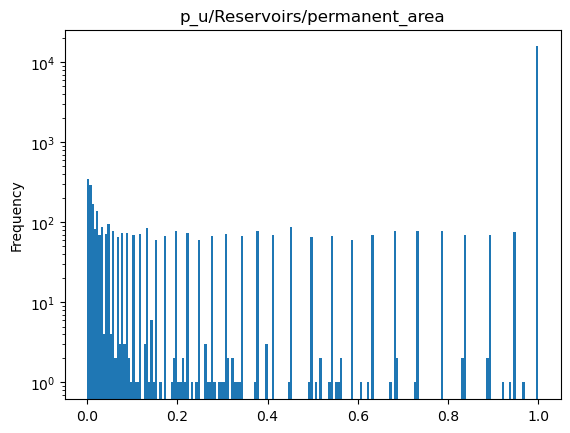

In [45]:
print(f'total_number_basins = {u_test.shape[0]}')
for p_th in [0.01, 0.02, 0.025, 0.05, 0.1]:
    num_of_change_basins = u_test[u_test['p_u'] < p_th].shape[0]
    print(f"p_th: {p_th}, numer of changed basins: {num_of_change_basins}, percentage: {num_of_change_basins / u_test.shape[0] *100:.2f}%")

u_test['p_u'].plot(kind='hist', bins=200, logy=True, title=f'p_u/{folder}/{area}')

<Axes: ylabel='Frequency'>

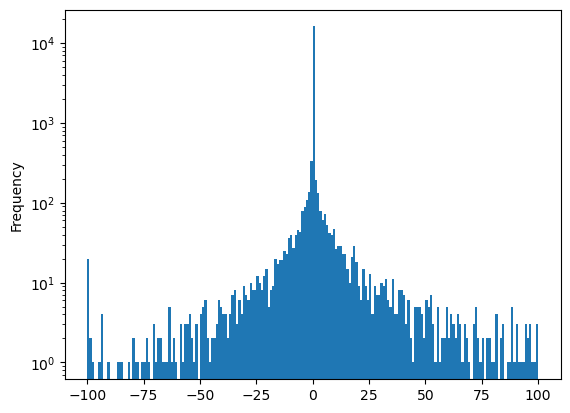

In [46]:

delta[delta[area] < 100][area].plot(kind='hist', bins=200, logy=True)

<Axes: ylabel='Frequency'>

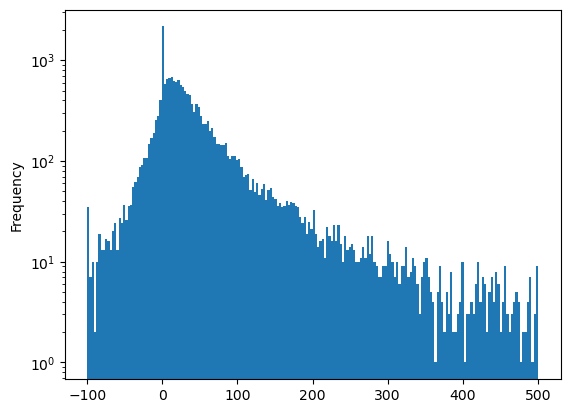

In [35]:
delta[delta[area] < 500][area].plot(kind='hist', bins=200, logy=True)

In [33]:
delta[delta[area] < 500].describe()

,start_year,basin_level,seasonal_area,PFAF_ID,Country_ID,sign
count,18215.0,18215.0,18215.000000,18215.000000,18215.000000,18215.000000
mean,2017.0,6.0,45.025099,434593.860280,405.992094,0.272632
std,0.0,0.0,75.380838,230848.086296,285.552477,0.481918
min,2017.0,6.0,-100.000000,111011.000000,4.000000,-1.000000
25%,2017.0,6.0,1.839306,227208.500000,124.000000,0.000000
50%,2017.0,6.0,23.262341,434694.000000,398.000000,0.000000
75%,2017.0,6.0,58.441324,631040.000000,643.000000,1.000000
max,2017.0,6.0,499.988432,999999.000000,1098.000000,1.000000


In [31]:
cut = 100
# 2.7263803080211018	23.98469613362817


print('mean', delta[(delta[area] < cut) & (delta[area] > -cut)][area].mean())
print('std', delta[(delta[area] < cut) & (delta[area] > -cut)][area].std())


mean 21.4147691405505
std 31.48910335147447
mean 21.4147691405505
std 31.48910335147447


In [20]:
delta[(delta[area] < 100) & (delta[area] > -100)][area].mean()

1.7589873796749584

In [1]:
import os
import pandas as pd
from pathlib import Path

def get_sign(x):
    if x > 0: return 1
    elif x < 0: return -1
    else: return 0

""" delta thresholds """
def get_delta_thresholds(basin_level, folder, area, alpha):
    df_thd = pd.read_csv(f"outputs_delta/{folder}/{area}/basin_level_mean_std.csv").set_index('basin_level')
    mean = df_thd[f'mean_{area}'].loc[basin_level]
    std = df_thd[f'std_{area}'].loc[basin_level]
    print(f"mean: {mean}, std: {std}")

    thd_low = mean - alpha * std 
    thd_high = mean + alpha * std 
    print(f"thd_low: {thd_low}, thd_high: {thd_high}")
    return mean, std, thd_low, thd_high


p_thd = 0.025
input_dir = Path("outputs_utest_V1")
for folder in os.listdir(input_dir):
    
    if 'Permanent_water' == folder: alpha = 1.5
    if 'Reservoirs' == folder: alpha = 1.0

    for area in os.listdir(input_dir / folder):
        save_dir = Path("outputs_utest_V1_decision") / folder / area
        save_dir.mkdir(exist_ok=True, parents=True)

        for basin_level in [6]:
            print()
            print(f"{folder}/{area}/basin_level: {basin_level}/alpha: {alpha}/p_thd: {p_thd}")

            df = pd.read_csv( input_dir / folder / area / f"basins_level_{basin_level}_utest.csv")
            mean, std, thd_low, thd_high = get_delta_thresholds(basin_level, folder, area, alpha)

            df['decision'] = None
            df['decision'][(df['p_u'] < p_thd) & (df['delta'] < 0)] = -1 # decreased basins determined by utest
            df['decision'][(df['p_u'] < p_thd) & (df['delta'] > 0)] = 1 # increased basins  determined by utest
            df['decision'][df['p_u'] >= p_thd] = 0 # non-change determined by u-test
            df['decision'][(thd_low <= df['delta']) & (df['delta'] <= thd_high)] = 0 # non-change determined by delta mean and std
            df['decision'][df['baseline_median'] < 0.0225] = -99 # dry basins

            print(df['decision'].unique())
            num_99 = df[df['decision'] == 99].shape[0]
            neg = df[df['decision'] == -1].shape[0]
            stable = df[df['decision'].abs() != 1].shape[0]
            pos = df[df['decision'] == 1].shape[0]
            print(f"total: {df.shape[0]}, neg: {neg}, stable: {stable}, pos: {pos}, num_99: {num_99}")

            df['mean'] = mean
            df['std'] = std
            df['thd_low'] = thd_low
            df['thd_high'] = thd_high
            df['alpha'] = alpha
            df['p_thd'] = p_thd

            df = df[['id_bgl', 'basin_level', 'start_year', 't_score', 'p_t', 'u_score', 'mean', 'std', 'alpha', 
                     'thd_low', 'thd_high', 'baseline_median', 'delta','p_u', 'p_thd', 'decision']]
            
            df.set_index('id_bgl').to_csv(save_dir / f"basins_level_{basin_level}_utest.csv")


Permanent_water/permanent_area/basin_level: 6/alpha: 1.5/p_thd: 0.025
mean: -0.768410471435599, std: 14.397894467900349
thd_low: -22.36525217328612, thd_high: 20.828431230414925
[-1 0 1 -99]
total: 95815, neg: 1482, stable: 91684, pos: 2649, num_99: 0


C:\Users\puzh\AppData\Local\Temp\ipykernel_12352\3603867907.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decision'][(df['p_u'] < p_thd) & (df['delta'] < 0)] = -1 # decreased basins determined by utest
C:\Users\puzh\AppData\Local\Temp\ipykernel_12352\3603867907.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decision'][(df['p_u'] < p_thd) & (df['delta'] > 0)] = 1 # increased basins  determined by utest
C:\Users\puzh\AppData\Local\Temp\ipykernel_12352\3603867907.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

In [26]:
df['ADMO_CODE']

0        818
1        818
2        818
3        818
4        818
        ... 
95810    795
95811    795
95812    795
95813    795
95814    795
Name: ADMO_CODE, Length: 95815, dtype: object

In [30]:
country = df.groupby(by='ADMO_CODE').get_group('36')
country

,id_bgl,basin_level,start_year,t_score,p_t,u_score,mean,std,alpha,thd_low,thd_high,baseline_median,delta,p_u,p_thd,decision,ADMO_CODE
62055,531510_36,6,2000,-0.077591,0.940183,43.5,-0.76841,14.397894,1.5,-22.365252,20.828431,10.800329,-6.126564,0.683265,0.025,0,36
62056,531510_36,6,2005,1.998682,0.058992,66.5,-0.76841,14.397894,1.5,-22.365252,20.828431,10.800329,2.101114,0.276581,0.025,0,36
62057,531510_36,6,2010,0.995946,0.340620,57.5,-0.76841,14.397894,1.5,-22.365252,20.828431,10.800329,1.090569,0.634064,0.025,0,36
62058,531510_36,6,2015,-1.181814,0.291326,32.5,-0.76841,14.397894,1.5,-22.365252,20.828431,10.800329,-17.594027,0.247667,0.025,0,36
62059,531510_36,6,2017,0.932877,0.386047,67.5,-0.76841,14.397894,1.5,-22.365252,20.828431,10.800329,7.455045,0.247849,0.025,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67710,574000_36,6,2000,NaN,NaN,50.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000000,0.000000,1.000000,0.025,-99,36
67711,574000_36,6,2005,NaN,NaN,50.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000000,0.000000,1.000000,0.025,-99,36
67712,574000_36,6,2010,NaN,NaN,50.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000000,0.000000,1.000000,0.025,-99,36
67713,574000_36,6,2015,NaN,NaN,50.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000000,0.000000,1.000000,0.025,-99,36


In [41]:
pos, neg

(start_year
 2000     9
 2005     1
 2010     8
 2015    12
 2017    40
 Name: decision, dtype: int64,
 start_year
 2000    13
 2005    11
 2010     5
 2015    13
 2017    10
 Name: decision, dtype: int64)

In [44]:
pos.loc[2000]

9

In [46]:
count = []
for start_year in pos.index:
    count += [pos.loc[start_year], neg.loc[start_year]]
count

[9, 13, 1, 11, 8, 5, 12, 13, 40, 10]

In [116]:
country = df.groupby(by='adm0_code').get_group(36)
xx = country.groupby(by='start_year').get_group(2017)
xx['decision'].shape


(986,)

In [48]:
df

,id_bgl,basin_level,start_year,t_score,p_t,u_score,mean,std,alpha,thd_low,thd_high,baseline_median,delta,p_u,p_thd,decision,ADMO_CODE
0,111011_818,6,2000,-4.283685,2.777692e-04,12.5,-0.76841,14.397894,1.5,-22.365252,20.828431,0.442409,-22.885471,0.011867,0.025,-1,818
1,111011_818,6,2005,-2.112744,4.568757e-02,39.5,-0.76841,14.397894,1.5,-22.365252,20.828431,0.442409,-10.922689,0.496492,0.025,0,818
2,111011_818,6,2010,0.742499,4.697880e-01,62.5,-0.76841,14.397894,1.5,-22.365252,20.828431,0.442409,24.182424,0.414486,0.025,0,818
3,111011_818,6,2015,3.945547,2.333263e-03,85.5,-0.76841,14.397894,1.5,-22.365252,20.828431,0.442409,59.218120,0.017309,0.025,1,818
4,111011_818,6,2017,3.630331,1.696974e-02,95.5,-0.76841,14.397894,1.5,-22.365252,20.828431,0.442409,78.246918,0.002221,0.025,1,818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95810,999999_795,6,2000,-2.799648,1.026168e-02,23.5,-0.76841,14.397894,1.5,-22.365252,20.828431,62603.629725,-0.450870,0.077052,0.025,0,795
95811,999999_795,6,2005,-2.115511,4.569030e-02,41.5,-0.76841,14.397894,1.5,-22.365252,20.828431,62603.629725,-0.091466,0.586430,0.025,0,795
95812,999999_795,6,2010,-2.168635,4.203671e-02,47.5,-0.76841,14.397894,1.5,-22.365252,20.828431,62603.629725,-0.012561,0.891818,0.025,0,795
95813,999999_795,6,2015,7.433548,4.430765e-07,87.5,-0.76841,14.397894,1.5,-22.365252,20.828431,62603.629725,5.139494,0.011867,0.025,0,795


In [62]:
res

,,ADM0_CODE,count_basins_plus_2000_2004,count_basins_negative_2000_2004,count_basins_plus_2005_2009,count_basins_negative_2005_2009,count_basins_plus_2010_2014,count_basins_negative_2010_2014,count_basins_plus_2015_2019,count_basins_negative_2015_2019,count_basins_plus_2017_2021,count_basins_negative_2017_2021
ADMO_CODE,,,,,,,,,,,,
100,0,100,0,1,0,0,0,0,2,0,1,0
1012,0,1012,0,0,0,0,0,0,0,0,0,0
1013,0,1013,0,0,0,0,0,0,0,0,0,0
1014,0,1014,0,0,0,0,0,0,0,2,0,1
1015,0,1015,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,887,0,0,0,0,0,1,3,0,6,0
894,0,894,1,5,0,0,2,0,9,4,17,3
90,0,90,0,0,0,0,0,0,2,1,4,1


In [94]:
country_name = pd.read_csv("data\Permanent_water\gaul_0_ts.csv")
country_name = country_name[['adm0_code', 'adm0_name']].set_index('adm0_code').drop_duplicates()
country_name

,adm0_name
adm0_code,
4,Afghanistan
8,Albania
12,Algeria
20,Andorra
24,Angola
...,...
1047,Tromelin Island
1048,Wake Island
1049,West Bank


In [128]:
df = pd.read_csv("outputs_utest_V1_decision\Permanent_water\permanent_area/basins_level_6_utest.csv")
df['adm0_code'] = df['id_bgl'].transform(lambda x: eval(x.split("_")[-1]))    

df[df['adm0_code']==4][df['start_year']==2005]

C:\Users\puzh\AppData\Local\Temp\ipykernel_12352\2298812086.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['adm0_code']==4][df['start_year']==2005]


,id_bgl,basin_level,start_year,t_score,p_t,u_score,mean,std,alpha,thd_low,thd_high,baseline_median,delta,p_u,p_thd,decision,adm0_code
30581,281062_4,6,2005,NaN,NaN,50.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000000,0.000000,1.000000,0.025,-99,4
30606,281066_4,6,2005,-0.930123,0.367501,45.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000367,-97.344896,0.741489,0.025,-99,4
30621,281068_4,6,2005,NaN,NaN,50.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000000,0.000000,1.000000,0.025,-99,4
30631,281069_4,6,2005,0.355370,0.733450,56.5,-0.76841,14.397894,1.5,-22.365252,20.828431,3.344264,4.177209,0.683265,0.025,0,4
30661,281091_4,6,2005,0.952970,0.380293,66.0,-0.76841,14.397894,1.5,-22.365252,20.828431,0.000366,681.402059,0.268842,0.025,-99,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56986,461966_4,6,2005,1.214036,0.238872,61.5,-0.76841,14.397894,1.5,-22.365252,20.828431,29.812419,0.109581,0.454447,0.025,0,4
56996,461967_4,6,2005,0.386226,0.704985,52.5,-0.76841,14.397894,1.5,-22.365252,20.828431,31.676549,0.623313,0.891818,0.025,0,4
57011,461968_4,6,2005,0.706358,0.487289,45.5,-0.76841,14.397894,1.5,-22.365252,20.828431,4.183125,-1.558519,0.785616,0.025,0,4
57021,461969_4,6,2005,0.559430,0.589521,57.5,-0.76841,14.397894,1.5,-22.365252,20.828431,15.756891,0.185202,0.634064,0.025,0,4


In [129]:
# df['ADMO_CODE'] = df['id_bgl'].transform(lambda x: x.split("_")[-1]) 
# df['ADMO_CODE'].unique()

country_name = pd.read_csv("data\Permanent_water\gaul_0_ts.csv")
country_name = country_name[['adm0_code', 'adm0_name']].set_index('adm0_code').drop_duplicates()

def count_by_peroid(group):
    adm0_code = group.index[0]
    decision = group.groupby(by='start_year')['decision']
    pos = decision.aggregate(lambda x: (x == 1).sum())
    neg = decision.aggregate(lambda x: (x == -1).sum())
    total_basins = decision.get_group(2017).shape[0]

    count = [adm0_code]
    for start_year in pos.index:
        count += [pos.loc[start_year], neg.loc[start_year]]
    count.append(total_basins)

    return pd.DataFrame(data=[count], columns=['ADM0_CODE', 
            'count_basins_plus_2000_2004', 'count_basins_negative_2000_2004',
            'count_basins_plus_2005_2009', 'count_basins_negative_2005_2009',
            'count_basins_plus_2010_2014', 'count_basins_negative_2010_2014',
            'count_basins_plus_2015_2019', 'count_basins_negative_2015_2019',
            'count_basins_plus_2017_2021', 'count_basins_negative_2017_2021',
            'total_basins'
        ])

df['adm0_code'] = df['id_bgl'].transform(lambda x: eval(x.split("_")[-1]))    
df_count = df.groupby(by='adm0_code').apply(count_by_peroid).reset_index().set_index('adm0_code').drop(columns=['level_1'])
df_count = pd.merge(country_name, df_count, how='inner', left_index=True, right_index=True)

# df_count.to_excel("csv/test.xlsx")
df_count

,adm0_name,ADM0_CODE,count_basins_plus_2000_2004,count_basins_negative_2000_2004,count_basins_plus_2005_2009,count_basins_negative_2005_2009,count_basins_plus_2010_2014,count_basins_negative_2010_2014,count_basins_plus_2015_2019,count_basins_negative_2015_2019,count_basins_plus_2017_2021,count_basins_negative_2017_2021,total_basins
adm0_code,,,,,,,,,,,,,
4,Afghanistan,30580,0,1,1,0,0,0,0,0,1,0,124
8,Albania,23330,0,0,0,0,0,0,0,0,2,0,9
12,Algeria,10685,0,12,0,0,0,0,6,1,5,1,321
20,Andorra,23910,0,0,0,0,0,0,0,0,0,0,2
24,Angola,3485,2,5,0,0,1,0,9,4,12,3,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,Juan de Nova Island,22890,0,0,0,0,0,0,0,0,0,0,1
1047,Tromelin Island,22925,0,0,0,0,0,0,0,0,0,0,1
1048,Wake Island,62545,0,0,0,0,0,0,0,0,0,0,1


In [60]:
res.columns

Index(['ADM0_CODE', 'count_basins_plus_2000_2004',
       'count_basins_negative_2000_2004', 'count_basins_plus_2005_2009',
       'count_basins_negative_2005_2009', 'count_basins_plus_2010_2014',
       'count_basins_negative_2010_2014', 'count_basins_plus_2015_2019',
       'count_basins_negative_2015_2019', 'count_basins_plus_2017_2021',
       'count_basins_negative_2017_2021'],
      dtype='object')

In [71]:
df.columns

Index(['id_bgl', 'basin_level', 'start_year', 't_score', 'p_t', 'u_score',
       'p_u', 'baseline_median', 'delta', 'u_sign', 'decision'],
      dtype='object')